In [1]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import string

import numpy as np

import pandas as pd

from joblib import Parallel, delayed
from tqdm import tqdm

from rdmc.mol import RDKitMol
from rdkit.Chem.Descriptors import ExactMolWt, NumRadicalElectrons
from rdkit.Chem.rdMolDescriptors import CalcNumRings, CalcNumHBD, CalcNumHeavyAtoms, CalcNumRotatableBonds
from rdkit.Chem import GetPeriodicTable

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from rmgpy.molecule import Molecule
from rmgpy.data.thermo import ThermoDatabase, ThermoGroups, ThermoData


from tree.parameters import Ts, columns

In [2]:
HBI_correction_df = pd.read_csv("../data/hbi.csv")
HBI_correction_df

,radical_smiles,resonance_radical_smiles,resonance_radical_num_rotatable_bonds,radical_H298 (kcal/mol),radical_Sint298 (cal/mol/K),radical_source,radical_level_of_theory,radical_Cp300 (cal/mol/K),radical_Cp400 (cal/mol/K),radical_Cp500 (cal/mol/K),...,closed_shell_thermo_source,HBI_H298 (kcal/mol),HBI_Sint298 (cal/mol/K),HBI_Cp300 (cal/mol/K),HBI_Cp400 (cal/mol/K),HBI_Cp500 (cal/mol/K),HBI_Cp600 (cal/mol/K),HBI_Cp800 (cal/mol/K),HBI_Cp1000 (cal/mol/K),HBI_Cp1500 (cal/mol/K)
0,[O]C(=O)OC(O)(O)O,[O]C(=O)OC(O)(O)O,4,-223.514126,95.999974,dong_pio_liang.py,CBS-QB3,33.926878,38.387673,41.508496,...,GAV,101.203465,-4.589644,2.364565,1.559776,0.412894,-0.172027,-1.041685,-1.683176,-3.705453
1,[O]C(O)(O)OC(=O)O,[O]C(O)(O)OC(=O)O,3,-223.423390,92.781436,dong_pio_liang.py,CBS-QB3,32.531179,37.569659,41.498443,...,GAV,101.294200,-7.808181,0.968866,0.741762,0.402841,0.476043,0.534574,0.412253,-1.394250
2,O=C(O)O[C](O)O,O=C(O)O[C](O)O,3,-187.322869,89.517068,dong_pio_liang.py,CBS-QB3,28.973242,34.553073,38.746721,...,GAV,96.140974,-4.610350,1.758768,2.587490,2.714389,2.346110,1.178471,0.282207,-0.997631
3,CC(=O)OC(OO)C(=O)C(O)O[O],CC(=O)OC(OO)C(=O)C(O)O[O],8,-185.660577,132.633380,dong_pio_liang.py,CBS-QB3,56.569703,66.028226,73.603744,...,GAV,100.658735,-12.393484,3.863088,3.589450,2.161239,1.702481,1.262146,-0.928170,-3.176204
4,O=[C]OC(O)(O)O,O=[C]OC(O)(O)O,5,-180.497563,90.031975,dong_pio_liang.py,CBS-QB3,32.378191,36.844343,39.334179,...,GAV,88.101481,-4.835845,5.443029,5.881647,4.696512,3.708683,1.768296,0.144000,-3.234417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,C1=C[CH]C=1,[C]1=CC=C1,0,156.106582,65.385768,dong_pio_liang.py,CBS-QB3,14.653111,18.488757,21.562144,...,GAV,103.873082,3.435468,-0.850889,-1.431243,-1.911856,-2.405821,-3.006968,-3.449835,-4.556360
2805,C=C=C1C=[C]C1,C=C=C1C=[C]C1,0,157.733085,77.587625,dong_pio_liang.py,CBS-QB3,22.675255,28.333884,32.976246,...,GAV,118.466211,25.815240,0.258337,-1.155381,-2.024215,-2.373362,-2.314548,-2.090808,-2.168527
2806,[CH2]C1=CC#CC1,[CH2]C1=CC#CC1,1,163.498344,75.963844,dong_pio_liang.py,CBS-QB3,22.606638,28.495118,33.391100,...,GAV,84.371344,0.823844,-0.802362,-1.521882,-1.227900,-2.500041,-3.127836,-3.711522,-2.960733
2807,[CH2]C1=CC#CC1,C=C1[CH]C#CC1,0,163.498344,75.963844,dong_pio_liang.py,CBS-QB3,22.606638,28.495118,33.391100,...,GAV,78.831344,0.773844,-0.212362,-0.521882,-0.797900,-1.120041,-2.017836,-2.931522,-2.570733


# Get data statistics

In [38]:
temp_df = HBI_correction_df.drop_duplicates("radical_smiles")
temp_df

,radical_smiles,resonance_radical_smiles,resonance_radical_num_rotatable_bonds,radical_H298 (kcal/mol),radical_Sint298 (cal/mol/K),radical_source,radical_level_of_theory,radical_Cp300 (cal/mol/K),radical_Cp400 (cal/mol/K),radical_Cp500 (cal/mol/K),...,HBI_H298 (kcal/mol),HBI_Sint298 (cal/mol/K),HBI_Cp300 (cal/mol/K),HBI_Cp400 (cal/mol/K),HBI_Cp500 (cal/mol/K),HBI_Cp600 (cal/mol/K),HBI_Cp800 (cal/mol/K),HBI_Cp1000 (cal/mol/K),HBI_Cp1500 (cal/mol/K),abs_HBI_Cp1500 (cal/mol/K)
0,[O]C(=O)OC(O)(O)O,[O]C(=O)OC(O)(O)O,4,-223.514126,95.999974,dong_pio_liang.py,CBS-QB3,33.926878,38.387673,41.508496,...,101.203465,-4.589644,2.364565,1.559776,0.412894,-0.172027,-1.041685,-1.683176,-3.705453,3.705453
1,[O]C(O)(O)OC(=O)O,[O]C(O)(O)OC(=O)O,3,-223.423390,92.781436,dong_pio_liang.py,CBS-QB3,32.531179,37.569659,41.498443,...,101.294200,-7.808181,0.968866,0.741762,0.402841,0.476043,0.534574,0.412253,-1.394250,1.394250
2,O=C(O)O[C](O)O,O=C(O)O[C](O)O,3,-187.322869,89.517068,dong_pio_liang.py,CBS-QB3,28.973242,34.553073,38.746721,...,96.140974,-4.610350,1.758768,2.587490,2.714389,2.346110,1.178471,0.282207,-0.997631,0.997631
3,CC(=O)OC(OO)C(=O)C(O)O[O],CC(=O)OC(OO)C(=O)C(O)O[O],8,-185.660577,132.633380,dong_pio_liang.py,CBS-QB3,56.569703,66.028226,73.603744,...,100.658735,-12.393484,3.863088,3.589450,2.161239,1.702481,1.262146,-0.928170,-3.176204,3.176204
4,O=[C]OC(O)(O)O,O=[C]OC(O)(O)O,5,-180.497563,90.031975,dong_pio_liang.py,CBS-QB3,32.378191,36.844343,39.334179,...,88.101481,-4.835845,5.443029,5.881647,4.696512,3.708683,1.768296,0.144000,-3.234417,3.234417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799,C=C=C1[CH]C1=C,C=C=C1[CH]C1=C,0,148.970420,81.360924,dong_pio_liang.py,CBS-QB3,25.185446,30.771706,34.989720,...,88.302446,25.437539,1.176527,0.728440,0.047260,-0.493509,-0.957762,-1.128172,-1.774846,1.774846
2802,[CH]=C1C=C1,[CH]=C1C=C1,0,152.166735,67.511963,dong_pio_liang.py,CBS-QB3,16.390064,19.702535,22.399354,...,103.530735,2.926263,0.013064,-0.834465,-1.465646,-2.011320,-2.766687,-3.372700,-4.666681,4.666681
2803,C1=C[CH]C=1,C1=C[CH]C=1,0,156.106582,65.385768,dong_pio_liang.py,CBS-QB3,14.653111,18.488757,21.562144,...,83.903082,-3.184532,0.069111,0.468757,0.368144,-0.325821,-1.506968,-2.489835,-3.976360,3.976360
2805,C=C=C1C=[C]C1,C=C=C1C=[C]C1,0,157.733085,77.587625,dong_pio_liang.py,CBS-QB3,22.675255,28.333884,32.976246,...,118.466211,25.815240,0.258337,-1.155381,-2.024215,-2.373362,-2.314548,-2.090808,-2.168527,2.168527


In [40]:
counts = temp_df.value_counts("radical_source")
counts

radical_source
dong_pio_liang.py     1980
pang.py                187
johnson_g4.py           36
johnson_cbs-qb3.py       9
dtype: int64

In [41]:
counts["dong_pio_liang.py"] + counts["pang.py"] + counts["johnson_cbs-qb3.py"]

2176

In [43]:
counts = HBI_correction_df.value_counts("closed_shell_thermo_source")
counts

closed_shell_thermo_source
GAV                                           1826
Thermo library: ../data/dong_pio_liang.py      875
Thermo library: ../data/pang.py                 81
Thermo library: ../data/johnson_g4.py           22
Thermo library: ../data/johnson_cbs-qb3.py       5
dtype: int64

In [44]:
counts["Thermo library: ../data/dong_pio_liang.py"] + counts["Thermo library: ../data/pang.py"] + counts["Thermo library: ../data/johnson_cbs-qb3.py"]


961

# Plot HBI distribution

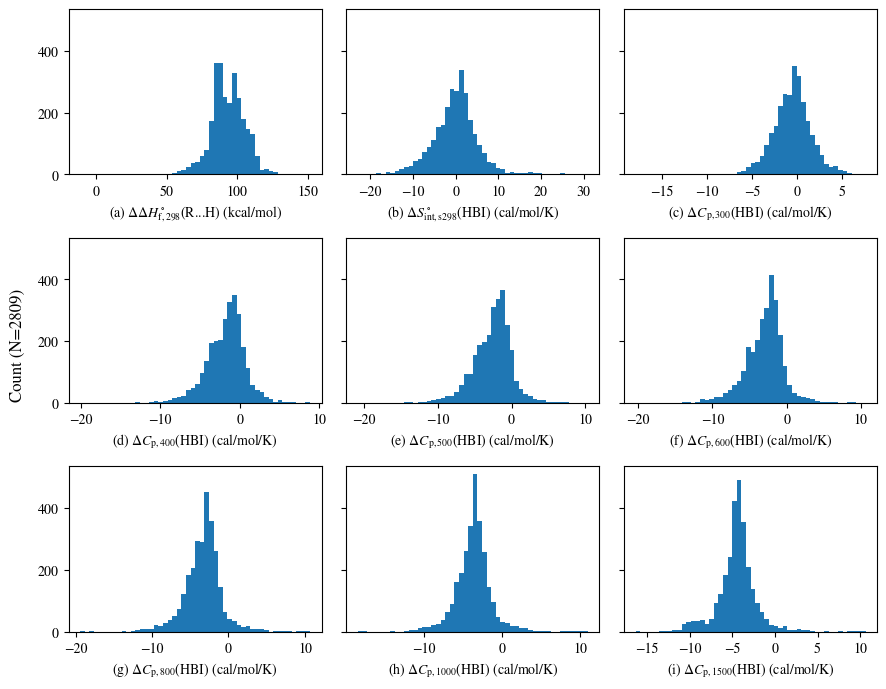

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
ax = axs.flat[0]
ax.hist(HBI_correction_df["HBI_H298 (kcal/mol)"], bins=50)
ax.set_xlabel("(a) $\Delta \Delta H^\circ_\mathrm{f,298}$(R...H) (kcal/mol)")

ax = axs.flat[1]
ax.hist(HBI_correction_df["HBI_Sint298 (cal/mol/K)"], bins=50)
ax.set_xlabel("(b) $\Delta S^\circ_\mathrm{int,s298}$(HBI) (cal/mol/K)")

for ax, T, alph in zip(axs.flat[2:], Ts, list(string.ascii_lowercase)[2:]):
    ax.hist(HBI_correction_df[f"HBI_Cp{T} (cal/mol/K)"], bins=50)
    ax.set_xlabel(f"({alph}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$(HBI) (cal/mol/K)")

fig.supylabel(f'Count (N={len(HBI_correction_df.index)})')
fig.tight_layout()
fig.savefig("../figures/data_hbi_hist.pdf", bbox_inches="tight")

# Plot current HBI corrections in empirical tree

In [8]:
thermo_database = ThermoDatabase()
empirical_tree = ThermoGroups().load("/home/gridsan/hwpang/Software/RMG-database/input/thermo/groups/radical.py", thermo_database.local_context, thermo_database.global_context)
print(len(empirical_tree.entries.keys()))
print(sum([1 for entry in empirical_tree.entries.values() if isinstance(entry.data, ThermoData)]))

1994
1828


In [11]:
print(sum([1 for entry in empirical_tree.entries.values() if isinstance(entry.data, ThermoData) and entry.data.H298.uncertainty_si!=0.0]))


1580


In [35]:
temp_dict = {
    "label": [],
    "HBI_H298 (kcal/mol)": [],
}

for column in columns[2:]:
    temp_dict["HBI_"+column] = []
for label, entry in empirical_tree.entries.items():
    if isinstance(entry.data, ThermoData):
        temp_dict["label"].append(label)
        temp_dict["HBI_H298 (kcal/mol)"].append(entry.data.H298.value_si/4184)
        temp_dict["HBI_Sint298 (cal/mol/K)"].append(entry.data.S298.value_si/4.184)
        for i, T in enumerate(Ts):
            temp_dict[f"HBI_Cp{T} (cal/mol/K)"].append(entry.data.Cpdata.value_si[i]/4.184)
            
empirical_hbi_df = pd.DataFrame(temp_dict)

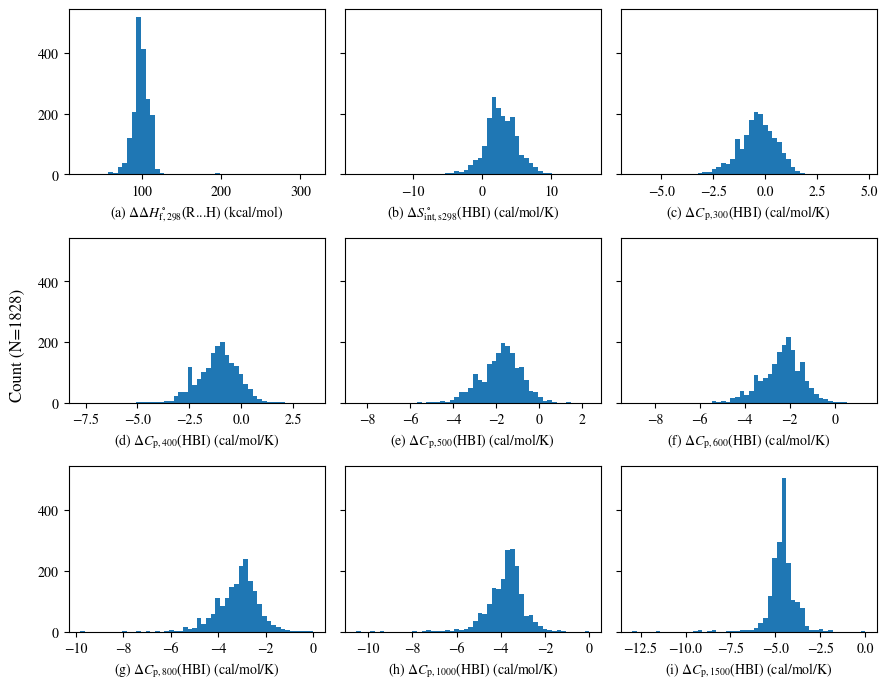

In [36]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
ax = axs.flat[0]
ax.hist(empirical_hbi_df["HBI_H298 (kcal/mol)"], bins=50)
ax.set_xlabel("(a) $\Delta \Delta H^\circ_\mathrm{f,298}$(R...H) (kcal/mol)")

ax = axs.flat[1]
ax.hist(empirical_hbi_df["HBI_Sint298 (cal/mol/K)"], bins=50)
ax.set_xlabel("(b) $\Delta S^\circ_\mathrm{int,s298}$(HBI) (cal/mol/K)")

for ax, T, alph in zip(axs.flat[2:], Ts, list(string.ascii_lowercase)[2:]):
    ax.hist(empirical_hbi_df[f"HBI_Cp{T} (cal/mol/K)"], bins=50)
    ax.set_xlabel(f"({alph}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$(HBI) (cal/mol/K)")

fig.supylabel(f'Count (N={len(empirical_hbi_df.index)})')
fig.tight_layout()
fig.savefig("../figures/empirical_hbi_hist.pdf", bbox_inches="tight")

# Analyze outliers

In [8]:
HBI_correction_df.columns

Index(['radical_smiles', 'resonance_radical_smiles',
       'resonance_radical_num_rotatable_bonds', 'radical_H298 (kcal/mol)',
       'radical_Sint298 (cal/mol/K)', 'radical_source',
       'radical_level_of_theory', 'radical_Cp300 (cal/mol/K)',
       'radical_Cp400 (cal/mol/K)', 'radical_Cp500 (cal/mol/K)',
       'radical_Cp600 (cal/mol/K)', 'radical_Cp800 (cal/mol/K)',
       'radical_Cp1000 (cal/mol/K)', 'radical_Cp1500 (cal/mol/K)',
       'closed_shell_smiles', 'closed_shell_H298 (kcal/mol)',
       'closed_shell_Cp300 (cal/mol/K)', 'closed_shell_Cp400 (cal/mol/K)',
       'closed_shell_Cp500 (cal/mol/K)', 'closed_shell_Cp600 (cal/mol/K)',
       'closed_shell_Cp800 (cal/mol/K)', 'closed_shell_Cp1000 (cal/mol/K)',
       'closed_shell_Cp1500 (cal/mol/K)', 'closed_shell_Sint298 (cal/mol/K)',
       'closed_shell_thermo_comment', 'closed_shell_thermo_source',
       'HBI_H298 (kcal/mol)', 'HBI_Sint298 (cal/mol/K)',
       'HBI_Cp300 (cal/mol/K)', 'HBI_Cp400 (cal/mol/K)',
       '

In [10]:
HBI_correction_df['closed_shell_thermo_source']

0       GAV
1       GAV
2       GAV
3       GAV
4       GAV
       ... 
2804    GAV
2805    GAV
2806    GAV
2807    GAV
2808    GAV
Name: closed_shell_thermo_source, Length: 2809, dtype: object

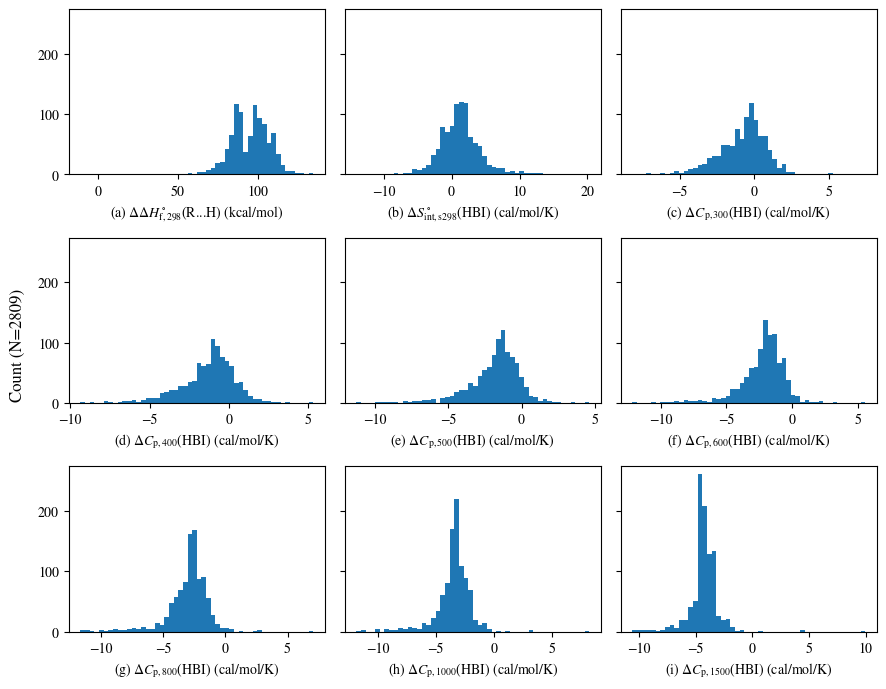

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))

query = HBI_correction_df['closed_shell_thermo_source'] != "GAV"
ax = axs.flat[0]
ax.hist(HBI_correction_df.loc[query, "HBI_H298 (kcal/mol)"], bins=50)
ax.set_xlabel("(a) $\Delta \Delta H^\circ_\mathrm{f,298}$(R...H) (kcal/mol)")

ax = axs.flat[1]
ax.hist(HBI_correction_df.loc[query, "HBI_Sint298 (cal/mol/K)"], bins=50)
ax.set_xlabel("(b) $\Delta S^\circ_\mathrm{int,s298}$(HBI) (cal/mol/K)")

for ax, T, alph in zip(axs.flat[2:], Ts, list(string.ascii_lowercase)[2:]):
    ax.hist(HBI_correction_df.loc[query, f"HBI_Cp{T} (cal/mol/K)"], bins=50)
    ax.set_xlabel(f"({alph}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$(HBI) (cal/mol/K)")

fig.supylabel(f'Count (N={len(HBI_correction_df.index)})')
fig.tight_layout()

In [17]:
temp_df = HBI_correction_df[HBI_correction_df["closed_shell_thermo_source"]!="GAV"]
temp_df["abs_HBI_Cp1500 (cal/mol/K)"] = temp_df["HBI_Cp1500 (cal/mol/K)"].abs()
temp_df = temp_df.sort_values("abs_HBI_Cp1500 (cal/mol/K)", ascending=False)
temp_df

/home/gridsan/hwpang/mambaforge/envs/rmg_rdmc_env_20230623_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,radical_smiles,resonance_radical_smiles,resonance_radical_num_rotatable_bonds,radical_H298 (kcal/mol),radical_Sint298 (cal/mol/K),radical_source,radical_level_of_theory,radical_Cp300 (cal/mol/K),radical_Cp400 (cal/mol/K),radical_Cp500 (cal/mol/K),...,HBI_H298 (kcal/mol),HBI_Sint298 (cal/mol/K),HBI_Cp300 (cal/mol/K),HBI_Cp400 (cal/mol/K),HBI_Cp500 (cal/mol/K),HBI_Cp600 (cal/mol/K),HBI_Cp800 (cal/mol/K),HBI_Cp1000 (cal/mol/K),HBI_Cp1500 (cal/mol/K),abs_HBI_Cp1500 (cal/mol/K)
888,O[C]1OO1,O[C]1OO1,1,-43.704234,61.902273,dong_pio_liang.py,CBS-QB3,11.210884,12.538098,13.644955,...,63.880639,-2.274509,-2.871300,-4.913751,-6.629171,-7.818231,-9.131844,-9.903273,-10.576350,10.576350
465,CC(COCOO)O[O],CC(COCOO)O[O],7,-72.371445,117.010286,johnson_g4.py,G4,44.489886,52.142055,58.763850,...,90.833780,6.434958,-0.530766,-4.097560,-6.771134,-8.764429,-11.105152,-11.837213,-10.291719,10.291719
136,CC(=O)OCC(C)(C)O[O],CC(=O)OCC(C)(C)O[O],6,-111.196200,121.678816,dong_pio_liang.py,CBS-QB3,44.897365,53.926520,62.135153,...,90.607857,10.145258,-1.290546,-3.917802,-6.156537,-8.138258,-10.645073,-11.080822,-10.091745,10.091745
1401,CC1OC1O[O],CC1OC1O[O],2,-16.889309,90.704260,johnson_g4.py,G4,29.583044,35.761125,41.219897,...,85.962533,4.150724,2.596126,3.580621,4.620631,5.543361,7.073366,8.240051,9.974335,9.974335
1328,[CH2]OC(CC)OO,[CH2]OC(CC)OO,6,-20.605939,111.110538,johnson_g4.py,G4,44.215949,49.288990,52.551286,...,119.721532,17.524613,7.461466,5.304945,2.192297,-0.942207,-5.549070,-7.874812,-9.927391,9.927391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,[O]OC(C=O)CCOO,[O]OC(C=O)CCOO,6,-58.323722,100.922672,dong_pio_liang.py,CBS-QB3,41.530340,50.495151,57.900672,...,85.753699,-4.405689,-3.893675,-2.018785,-0.480324,0.450731,0.596904,-0.208333,-1.372495,1.372495
666,OC[C]1OC1O,OC[C]1OC1O,3,-56.927344,79.034624,dong_pio_liang.py,CBS-QB3,23.545841,30.223751,35.991107,...,102.197247,-0.252313,-3.614767,-4.302420,-4.340273,-3.708749,-2.148898,-1.186640,-0.933265,0.933265
778,CC[CH]OCOO,CC[CH]OCOO,6,-49.829966,98.514394,johnson_g4.py,G4,33.387398,40.404439,46.667357,...,87.105754,4.732610,-2.648999,-2.626868,-2.662610,-2.552832,-2.099027,-1.583776,-0.852568,0.852568
309,O=C[C](O)C=CO,O=CC(O)=C[CH]O,4,-89.455500,81.441164,dong_pio_liang.py,CBS-QB3,25.983030,32.112494,37.527469,...,67.865336,-6.585663,-3.239082,-2.952888,-2.664124,-2.351519,-1.613869,-0.746460,0.779456,0.779456


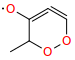

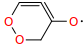

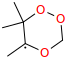

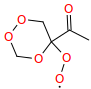

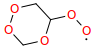

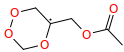

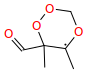

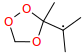

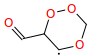

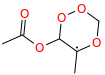

In [14]:
for smi in temp_df["resonance_radical_smiles"][:10]:
    mol = Molecule().from_smiles(smi)
    display(mol)